## импорты

In [71]:
import os
import warnings

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import (
    LabelEncoder,
    OneHotEncoder,
    StandardScaler,
    RobustScaler,
    MinMaxScaler,
)
from sklearn.metrics import confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier


from data_viz_functions import *


In [72]:
DATA_DIR = "kaggle/input/"
df_train = pd.read_csv(DATA_DIR + "/train.csv")
df_test = pd.read_csv(DATA_DIR + "/test.csv")
sample_submission = pd.read_csv(DATA_DIR + "/sample_submission.csv")

for dirname, _, filenames in os.walk(DATA_DIR):
    for filename in filenames:
        print(os.path.join(dirname, filename))


kaggle/input/sf-scoring.zip
kaggle/input/sample_submission.csv
kaggle/input/train.csv
kaggle/input/test.csv


In [73]:
df_train.dtypes


client_id             int64
app_date             object
education            object
sex                  object
age                   int64
car                  object
car_type             object
decline_app_cnt       int64
good_work             int64
score_bki           float64
bki_request_cnt       int64
region_rating         int64
home_address          int64
work_address          int64
income                int64
sna                   int64
first_time            int64
foreign_passport     object
default               int64
dtype: object

## объединяем трейн и тест для предобработки


In [74]:
df_train["sample"] = 1  # где у нас трейн
df_test["sample"] = 0  # где у нас тест
df_test[
    "default"
] = 0  # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True)  # объединяем


## группируем имена колонок в списки

In [75]:
num_cols = ["age", "decline_app_cnt", "score_bki", "bki_request_cnt", "income"]
cat_cols = [
    "education",
    "first_time",
    "sna",
    "work_address",
    "home_address",
    "region_rating",
]
bin_cols = ["sex", "car", "car_type", "good_work", "foreign_passport"]


### и смотрим

In [76]:
data[num_cols].sample(3)


,age,decline_app_cnt,score_bki,bki_request_cnt,income
19832,51,0,-2.542723,4,25000
32842,55,0,-2.426663,0,100000
95868,34,0,-1.708516,2,15000


In [77]:
describe_nums(data)


,unique,n/a count,count,mean,std,min,25%,50%,75%,max
client_id,110148,0,110148.000000,55074.500000,31797.133063,1.000000,27537.750000,55074.500000,82611.250000,110148.000000
score_bki,102618,0,110148.000000,-1.904535,0.499397,-3.624586,-2.260434,-1.920823,-1.567888,0.199773
income,1207,0,110148.000000,41012.648537,45399.735051,1000.000000,20000.000000,30000.000000,48000.000000,1000000.000000
app_date,120,0,nan,nan,nan,nan,nan,nan,nan,nan
age,52,0,110148.000000,39.249410,11.518063,21.000000,30.000000,37.000000,48.000000,72.000000
bki_request_cnt,40,0,110148.000000,2.005002,2.266926,0.000000,0.000000,1.000000,3.000000,53.000000
decline_app_cnt,24,0,110148.000000,0.273205,0.799099,0.000000,0.000000,0.000000,0.000000,33.000000
region_rating,7,0,110148.000000,56.751189,13.065923,20.000000,50.000000,50.000000,60.000000,80.000000
education,5,478,nan,nan,nan,nan,nan,nan,nan,nan
sna,4,0,110148.000000,1.731588,1.122652,1.000000,1.000000,1.000000,2.000000,4.000000


В образовании есть пропуски, предположим, что это значит "без образования"

In [78]:
data.education.fillna("NA", inplace=True)


### числовые

Unique values count: 52 
Q1: 30.0
Q3: 48.0
IQR: 18.0 
Outliers borders: [3.0, 75.0]


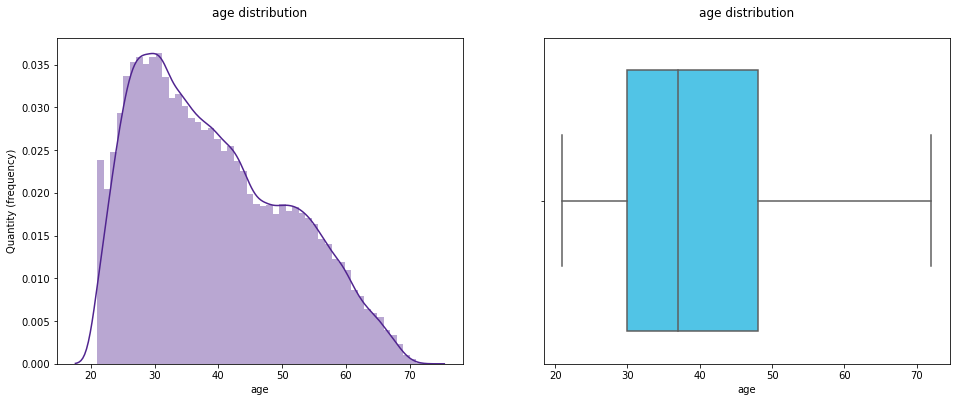

Unique values count: 24 
Q1: 0.0
Q3: 0.0
IQR: 0.0 
Outliers borders: [0.0, 0.0]


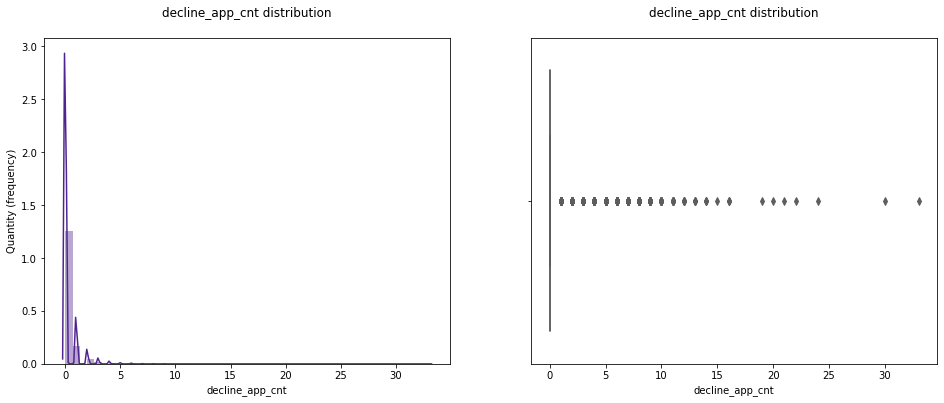

Unique values count: 102618 
Q1: -2.26044074
Q3: -1.5678840649999999
IQR: 0.6925566750000001 
Outliers borders: [-3.2992757525, -0.5290490524999998]


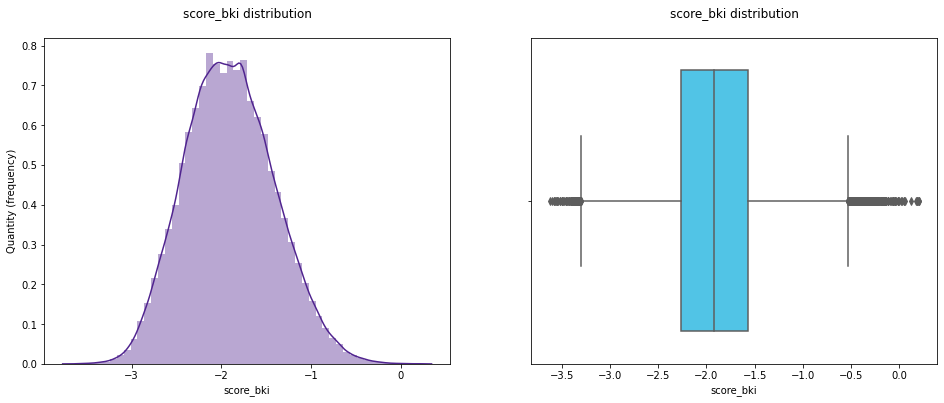

Unique values count: 40 
Q1: 0.0
Q3: 3.0
IQR: 3.0 
Outliers borders: [-4.5, 7.5]


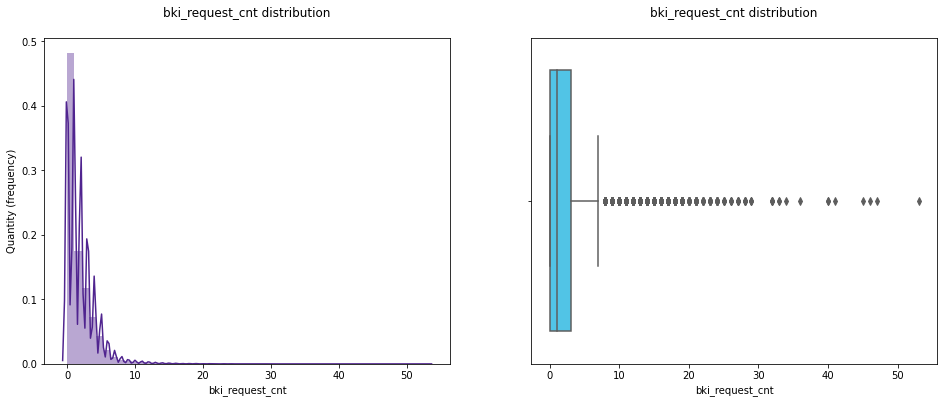

Unique values count: 1207 
Q1: 20000.0
Q3: 48000.0
IQR: 28000.0 
Outliers borders: [-22000.0, 90000.0]


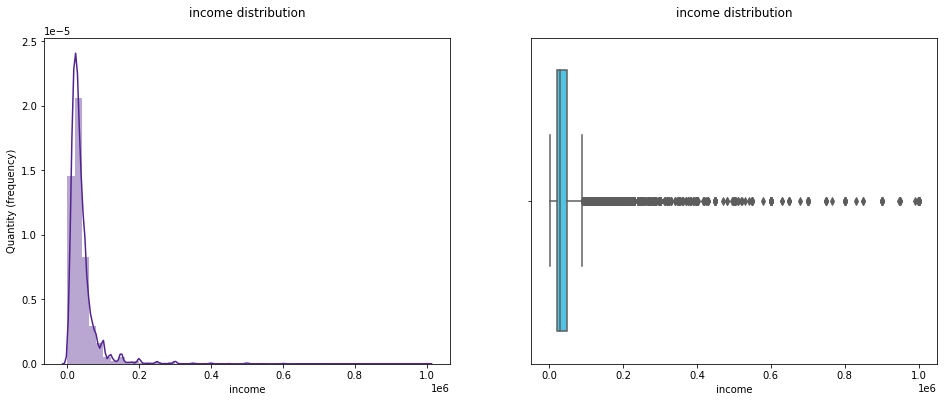

In [79]:
for n in num_cols:
    show_IQR(data[n])


Кроме score_bki все имеют выраженный хвост. Логорифмировать

<AxesSubplot:>

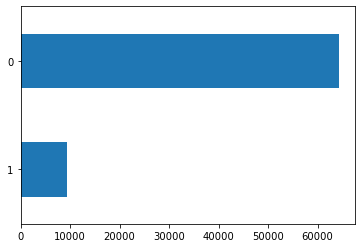

In [80]:
data.loc[data["sample"] == 1]["default"].value_counts(ascending=True).plot(kind="barh")


### корреляция и значимость признаков

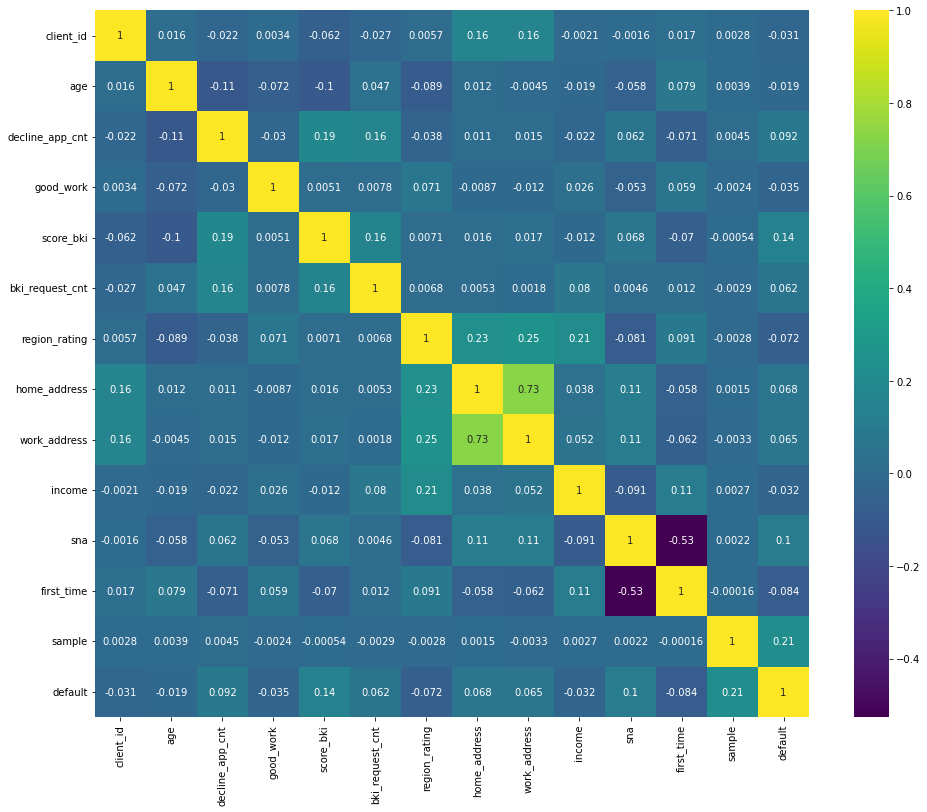

In [81]:
plt.subplots(figsize=(16, 13))
sns.heatmap(data.corr(), cmap="viridis", annot=True)
plt.show()


Рабочий и домашний дреса сильно скоррелированы

In [82]:
data.drop(
    [
        "client_id",
        "app_date",
    ],
    axis=1,
    inplace=True,
)


In [83]:
data = pd.get_dummies(data, columns=["education"], dummy_na=True)


In [84]:
le = LabelEncoder()

for column in bin_cols:
    data[column] = le.fit_transform(data[column])

columns = ["first_time", "sna", "work_address", "home_address", "region_rating"]

for column in columns:
    data[column] = le.fit_transform(data[column])


In [85]:
# Теперь выделим тестовую часть
train_data = data.query("sample == 1").drop(["sample"], axis=1)
test_data = data.query("sample == 0").drop(["sample", "default"], axis=1)

X = train_data.drop(["default"], axis=1)
y = train_data["default"].values  # наш таргет


In [86]:
# Воспользуемся специальной функцией train_test_split для разбивки тестовых данных
from sklearn.model_selection import train_test_split

# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [87]:
# проверяем
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((59039, 22), (14760, 22), (59039,), (14760,))

## проверяем модели без параметров



-= LOGISTIC REGRESSION =-


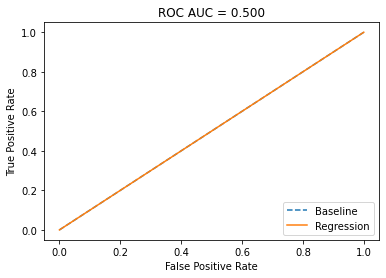

['              precision    recall  f1-score   support',
 '',
 '           0       0.87      1.00      0.93     51494',
 '           1       0.00      0.00      0.00      7545',
 '',
 '    accuracy                           0.87     59039',
 '   macro avg       0.44      0.50      0.47     59039',
 'weighted avg       0.76      0.87      0.81     59039',
 '']


-= RANDOM FOREST =-


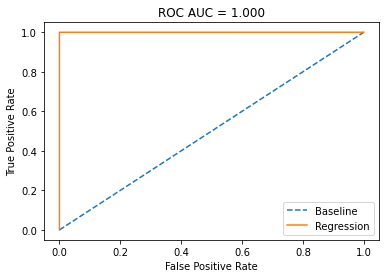

['              precision    recall  f1-score   support',
 '',
 '           0       1.00      1.00      1.00     51494',
 '           1       1.00      1.00      1.00      7545',
 '',
 '    accuracy                           1.00     59039',
 '   macro avg       1.00      1.00      1.00     59039',
 'weighted avg       1.00      1.00      1.00     59039',
 '']


-= HIST GRADIENT BOOSTING =-


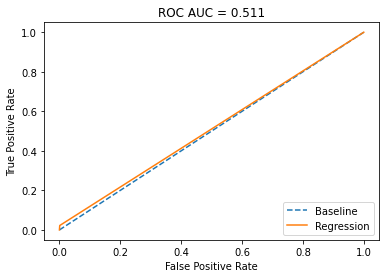

['              precision    recall  f1-score   support',
 '',
 '           0       0.87      1.00      0.93     51494',
 '           1       0.75      0.02      0.04      7545',
 '',
 '    accuracy                           0.87     59039',
 '   macro avg       0.81      0.51      0.49     59039',
 'weighted avg       0.86      0.87      0.82     59039',
 '']


-= CATBOOST =-
Learning rate set to 0.058777
0:	learn: 0.6464551	total: 7.53ms	remaining: 7.52s
1:	learn: 0.6099059	total: 13.8ms	remaining: 6.89s
2:	learn: 0.5755773	total: 21.8ms	remaining: 7.25s
3:	learn: 0.5449515	total: 29.1ms	remaining: 7.24s
4:	learn: 0.5183916	total: 37.1ms	remaining: 7.38s
5:	learn: 0.4960122	total: 43.3ms	remaining: 7.17s
6:	learn: 0.4765024	total: 49.3ms	remaining: 7s
7:	learn: 0.4613932	total: 56.8ms	remaining: 7.04s
8:	learn: 0.4473615	total: 62.3ms	remaining: 6.86s
9:	learn: 0.4364339	total: 66.6ms	remaining: 6.6s
10:	learn: 0.4266618	total: 73.9ms	remaining: 6.65s
11:	learn: 0.4171769	total: 81.1

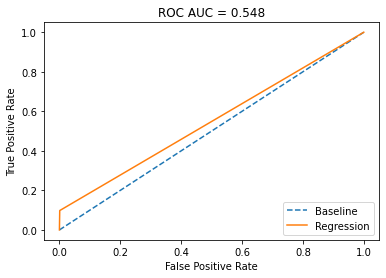

['              precision    recall  f1-score   support',
 '',
 '           0       0.88      1.00      0.94     51494',
 '           1       0.93      0.10      0.18      7545',
 '',
 '    accuracy                           0.88     59039',
 '   macro avg       0.91      0.55      0.56     59039',
 'weighted avg       0.89      0.88      0.84     59039',
 '']


-= LGBM =-


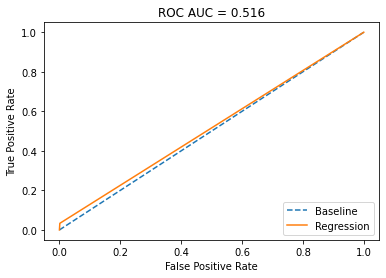

['              precision    recall  f1-score   support',
 '',
 '           0       0.88      1.00      0.93     51494',
 '           1       0.78      0.03      0.06      7545',
 '',
 '    accuracy                           0.88     59039',
 '   macro avg       0.83      0.52      0.50     59039',
 'weighted avg       0.86      0.88      0.82     59039',
 '']


In [95]:
for name, model in [
    ("\n\n-= LOGISTIC REGRESSION =-", LogisticRegression()),
    ("\n\n-= RANDOM FOREST =-", RandomForestClassifier()),
    ("\n\n-= HIST GRADIENT BOOSTING =-", HistGradientBoostingClassifier()),
    ("\n\n-= CATBOOST =-", CatBoostClassifier()),
    ("\n\n-= LGBM =-", LGBMClassifier()),
]:
    print(name)
    show_classification_details(y_train, model.fit(X_train, y_train).predict(X_train))


## final model

In [96]:
# если качество нас устраивает, обучаем финальную модель на всех обучающи данных
model_final = CatBoostClassifier()
model_final.fit(X, y)


Learning rate set to 0.064653
0:	learn: 0.6417429	total: 13.3ms	remaining: 13.3s
1:	learn: 0.6020013	total: 23.6ms	remaining: 11.8s
2:	learn: 0.5652311	total: 32.1ms	remaining: 10.7s
3:	learn: 0.5328459	total: 41.8ms	remaining: 10.4s
4:	learn: 0.5059065	total: 49.4ms	remaining: 9.82s
5:	learn: 0.4830122	total: 59.8ms	remaining: 9.91s
6:	learn: 0.4633076	total: 70.5ms	remaining: 10s
7:	learn: 0.4478031	total: 79.8ms	remaining: 9.9s
8:	learn: 0.4339089	total: 87.9ms	remaining: 9.67s
9:	learn: 0.4234764	total: 93.6ms	remaining: 9.27s
10:	learn: 0.4142284	total: 101ms	remaining: 9.09s
11:	learn: 0.4049886	total: 109ms	remaining: 8.98s
12:	learn: 0.3971596	total: 117ms	remaining: 8.85s
13:	learn: 0.3904283	total: 127ms	remaining: 8.96s
14:	learn: 0.3849338	total: 135ms	remaining: 8.85s
15:	learn: 0.3803458	total: 143ms	remaining: 8.79s
16:	learn: 0.3758740	total: 154ms	remaining: 8.88s
17:	learn: 0.3721780	total: 162ms	remaining: 8.85s
18:	learn: 0.3688409	total: 173ms	remaining: 8.94s
19:	

In [97]:
predict_submission = model_final.predict(test_data)


## submission


In [98]:
sample_submission["default"] = predict_submission
sample_submission.to_csv("submission.csv", index=False)
sample_submission.head(10)


,client_id,default
0,74835,0
1,17527,1
2,75683,0
3,26883,0
4,28862,0
5,99881,0
6,26630,0
7,79934,0
8,16605,0
9,105449,0


In [99]:
sample_submission.describe()


,client_id,default
count,36349.000000,36349.000000
mean,54945.647473,0.009051
std,31706.052195,0.094707
min,4.000000,0.000000
25%,27744.000000,0.000000
50%,54657.000000,0.000000
75%,82322.000000,0.000000
max,110148.000000,1.000000


In [93]:
# !kaggle competitions submit -c sf-scoring -f submission.csv -m "one more try"
